In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Check convergence -> 
# Priors, try Weavers and also log-normal 80 - 12000

<ipython-input-1-34eacf8e8380>:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## To do 
1. Add priors to posterior plots 
2. Save chain outputs and use these for predictive modelling 
3. Run log-uniform prior for diffusion coefficient 

# Attractant Dynamics Parameters

This notebook allows you to expermiment with how different attractant dynamics parameters create different levels of observed bias in different points in space and time. The model goes something like this:

The heat equation gives us a solution to calculate the concentration of attractant at any point $r$ and $t$ in space. It takes parameters $q$, $D$ and $\tau$, which represent the flow rate, the diffusion coefficient and the diffusion time respectively. This is then used, along with the theory of receptir-lingand binding kinetics, to predict the number of bound complexes that should appear on either side of a migrating leukocyte. This equation takes parameters $R_0$ and $\kappa_d$. Finally, the observed bias of a cell at time $t$ a distance $r$ from the wound is assumed to be linearly related to the difference between the concentration of bound receptors at the front and rear of the cell. 

This means, given a set of parameters $\theta = \{q, \, D, \, \tau, \, R_0, \, \kappa_d, \, m, \, b_0\}$, we can calculate the observed bias one would expect to occur at any point in space and time. 



In [2]:
# Import all the necessary modules needed to run the inference pipeline
import sys
import os

sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import corner
import seaborn as sns 
from inference.walker_inference import BiasedPersistentInferer, prepare_paths, spatial_temporal_binning
from inference.attractant_inference import AttractantInferer
from in_silico.sources import PointSource, PointWound
from scipy import stats
from scipy.special import expi
from matplotlib.patches import Circle

#from Utilities.plotting import plot_find_wound_location,plotxy_space_bins,plotxy_time_bins,observed_bias_plotting


In [3]:


distance = [20, 60, 100, 140, 180,220, 260]
time = [2.5,5,7.5,10,12.5,15,17.5,20]



In [4]:
ob_readings_control = {}
ob_readings_mcr = {}

# This function reads in previously run data from walker inference pipeline, and outputs the observed bias mean and std\
# for the dataframe. The inputs are x,y which correspond to the file formats


def bias_values_control(i, j): # Change to loading bias values
    input_data = np.load('../data/New_data/Control_data{}{}.npy'.format(i,j), allow_pickle=True)
    sampler = input_data[0]  # Extracts the posterior chain array from the input_data array
    # Removes the burn-in, thins the posterior data and flattens the walkers into a single array
    input_data = sampler.get_chain(discard=10, thin=10, flat=True)
    w = input_data[:, 0]  # The weighting parameter from the walker posterior array
    b = input_data[:, 2]  # The bias parameter from the walker posterior array
    obwt = (w * b)  # The observed bias parameter from the walker posterior array
    mean = np.mean(obwt)
    std = np.std(obwt)
    return mean, std


def bias_values_mcr(i, j): # Change to loading bias values
    input_data = np.load('../data/New_data/MCR_data{}{}.npy'.format(i,j), allow_pickle=True)
    sampler = input_data[0]  # Extracts the posterior chain array from the input_data array
    # Removes the burn-in, thins the posterior data and flattens the walkers into a single array
    input_data = sampler.get_chain(discard=10, thin=10, flat=True)
    w = input_data[:, 0]  # The weighting parameter from the walker posterior array
    b = input_data[:, 2]  # The bias parameter from the walker posterior array
    obwt = (w * b)  # The observed bias parameter from the walker posterior array
    mean = np.mean(obwt)
    std = np.std(obwt)
    return mean, std
"""
Here we define a nested for loop which populates the dictionary ob_readings with the mean and std of the current 
observed bias. This is then ready to be read into our attractant inference as the data for the inference pipeline. 
"""
for i in range(len(time)):
    for j in range(len(distance)):
        ObBias_cont = bias_values_control(j, i)
        ObBias_mcr = bias_values_mcr(j, i)

        ob_mean_cont = ObBias_cont[0]
        ob_std_cont = ObBias_cont[1]
        
        ob_mean_mcr = ObBias_mcr[0]
        ob_std_mcr = ObBias_mcr[1]
        ob_readings_control[(distance[j], time[i])] = (ob_mean_cont, ob_std_cont)
        ob_readings_mcr[(distance[j], time[i])] = (ob_mean_mcr, ob_std_mcr)

In [5]:
ob_readings_control;

In [100]:

n_walkers = 30
n_iter = 10000

# Sets the wound location
wound = PointWound(position=np.array([0, 0]))
inferer_cont = AttractantInferer(ob_readings_control, wound=wound, t_units='minutes')
# Emcee (Ensemble Monte Carlo)
Post_attractant_control = inferer_cont.ensembleinfer(n_walkers, n_iter, Pooling = True)
# This saves the Emcee output to the data folder


Running sampler: 


100%|██████████| 10000/10000 [03:50<00:00, 43.36it/s]


In [304]:
np.save('../data/New_data/Attractant_control', Post_attractant_control)

/Users/danieltudor/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [114]:

n_walkers = 30
n_iter = 10000

# Sets the wound location
wound = PointWound(position=np.array([0, 0]))
inferer_mcr = AttractantInferer(ob_readings_mcr, wound=wound, t_units='minutes')
# Emcee (Ensemble Monte Carlo)
Post_attractant_mcr = inferer_mcr.ensembleinfer(n_walkers, n_iter, Pooling = True)
# This saves the Emcee output to the data folder


Running sampler: 


100%|██████████| 10000/10000 [03:43<00:00, 44.70it/s]


In [305]:
np.save('../data/New_data/Attractant_post_mcr', Post_attractant_mcr)

In [5]:
Post_attractant_control = np.load("../data/New_data/Attractant_control.npy", allow_pickle=True)

In [6]:
Post_attractant_mcr = np.load("../data/New_data/Attractant_post_mcr.npy", allow_pickle=True)

In [7]:
labels = ['q','D','τ','R0','κ','m','b0']
ndim = len(labels)

chains = Post_attractant_control[0].get_chain()

In [12]:
# Trace Plots
plt.figure(figsize=(12, 6))
for dim in range(ndim):
    plt.subplot(ndim, 1, dim + 1)
    for walker in range(n_walkers):
        plt.plot(chains[:, walker, dim], alpha=0.5)
    plt.ylabel(labels[dim])
plt.xlabel("Iteration")
plt.tight_layout()
plt.savefig("Chains for control_1.pdf")
plt.show()

NameError: name 'n_walkers' is not defined

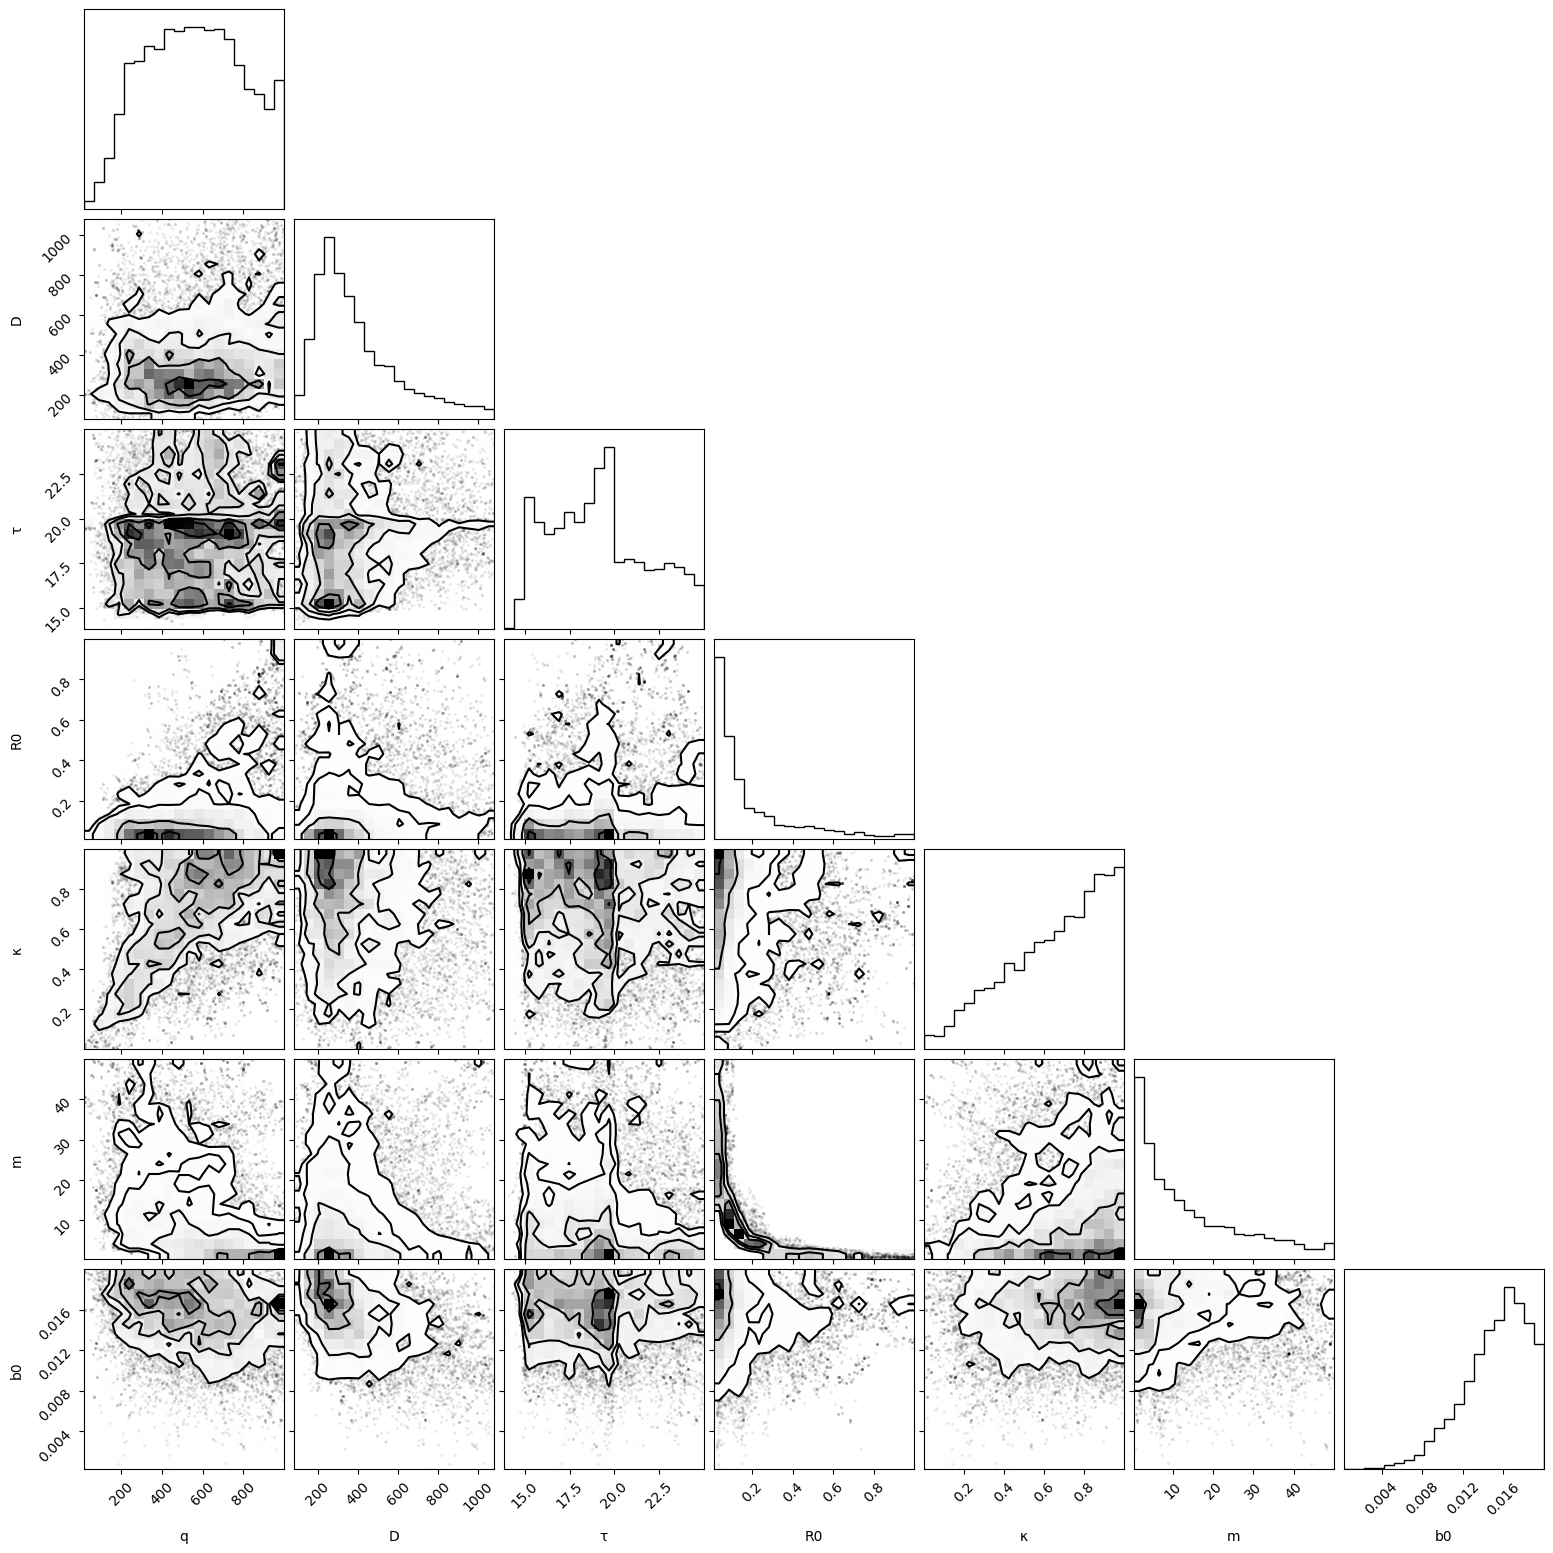

In [8]:
chains = Post_attractant_control[0].get_chain(discard=5000, thin=10)

# Pairwise Scatter Plots
labels = [labels[dim] for dim in range(ndim)]
samples = chains[:, :, :ndim].reshape(-1, ndim)
corner.corner(samples, labels=labels)
#plt.savefig("Pairwise-PDF-controls.pdf")

plt.show()


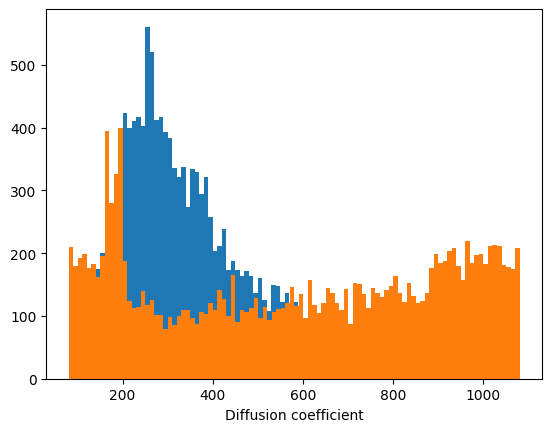

In [9]:
chains_mcr = Post_attractant_mcr[0].get_chain(discard=5000, thin=10, flat = True)
chains_control = Post_attractant_control[0].get_chain(discard=5000, thin=10, flat = True)
#chains_mcr
plt.hist(chains_control[:,1], bins = 100)
plt.hist(chains_mcr[:,1], bins = 100)

plt.xlabel("Diffusion coefficient")
plt.show()

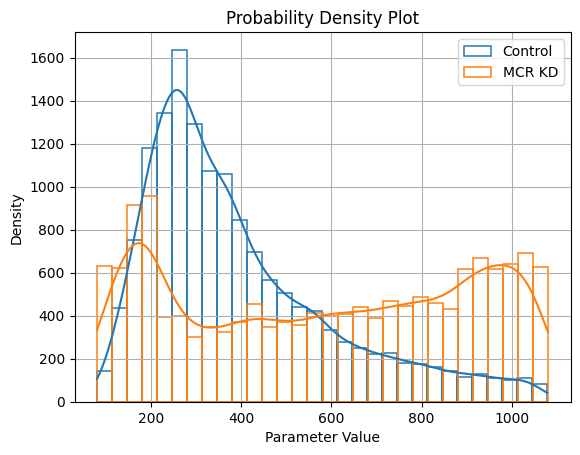

In [10]:
import seaborn as sns

# Create a histogram plot with seaborn
sns.histplot(chains_control[:,1],fill =False, kde=True, bins=30, label='Control')
sns.histplot(chains_mcr[:,1],fill =False,  kde=True,bins=30, label='MCR KD')

# Customize the plot
plt.xlabel('Parameter Value')
plt.ylabel('Density')
plt.title('Probability Density Plot')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

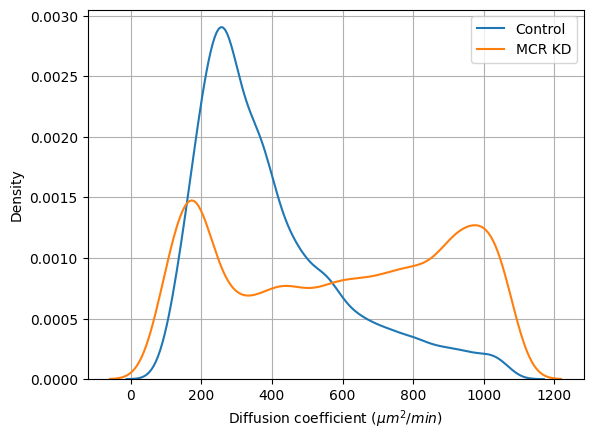

In [121]:
# Create a histogram plot with seaborn
sns.kdeplot(chains_control[:,1],label='Control')
sns.kdeplot(chains_mcr[:,1], label='MCR KD')

# Customize the plot
plt.xlabel('Diffusion coefficient ($\mu m^2/min$)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.savefig("Diffusion_coefficients.pdf")

# Show the plot
plt.show()

In [15]:
d = {'Diffusion-control': chains_control[:,1], 'Diffusion-mcr': chains_mcr[:,1], 'ProductionTime-control':chains_control[:,2], 'ProductionTime-mcr':chains_mcr[:,2]}
Posteriors = pd.DataFrame(data=d)

In [17]:
Posteriors.to_excel("Posterior_data.xlsx")

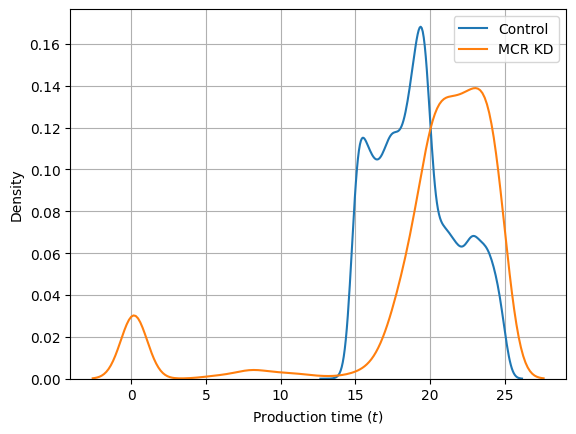

In [122]:
# Create a histogram plot with seaborn
sns.kdeplot(chains_control[:,2],label='Control')
sns.kdeplot(chains_mcr[:,2], label='MCR KD')

# Customize the plot
plt.xlabel('Production time ($t$)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.savefig("Production_time.pdf")

# Show the plot
plt.show()

In [119]:
# Log-uniform prior - knockdown for any other signal 
# Post 25 minutes, interest in attraction to the wound. If delayed production, longer video? 
# Write a draft methods: share via word (this afternoon 10th)

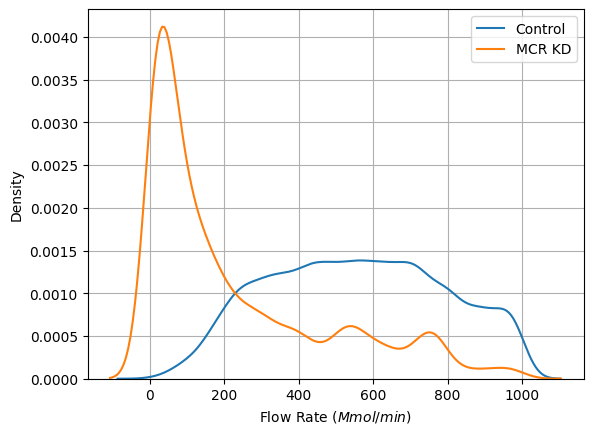

In [11]:
# Create a histogram plot with seaborn
sns.kdeplot(chains_control[:,0],label='Control')
sns.kdeplot(chains_mcr[:,0], label='MCR KD')

# Customize the plot
plt.xlabel('Flow Rate ($Mmol / min$)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
#plt.savefig("Diffusion_coefficients.pdf")

# Show the plot
plt.show()
# Check low flow rate at diffusivity for MCR 